# Neural Net to Predict Age

# Imports

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras.optimizers import Adam

# Data

In [5]:
data = pd.read_csv("./Volumetric_features.csv")

data_features = pd.DataFrame(data, columns = data.columns[:-1])
data_features = data_features.drop(['S.No','Age'], axis=1)

data_features.head()
data_features.describe()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent.2,eTIV.1
count,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,...,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03
mean,13370.040795,574.849716,14646.696711,52002.811571,7164.947539,3337.653526,4505.158755,1958.214458,1418.947373,1797.243469,...,2.117151,2.655624,2.429779,2.684327,3.555803,2.288283,2.846123,2.372266,1.085468e+06,1.514925e+06
std,9194.928348,594.590387,2622.868798,6378.435917,1207.229615,502.352001,713.658580,287.139826,635.143286,583.220321,...,0.174228,0.207942,0.185543,0.275245,0.332094,0.269851,0.195038,0.146944,1.248881e+05,1.651798e+05
min,2204.100000,0.000000,6920.100000,29911.800000,4145.400000,1035.600000,2294.000000,851.900000,39.700000,371.900000,...,1.499000,1.563000,1.345000,1.655000,1.940000,1.176000,1.533000,1.483290,6.279600e+05,8.329815e+05
25%,7031.625000,243.200000,12909.875000,47359.675000,6239.425000,2984.500000,4008.125000,1764.700000,941.825000,1408.050000,...,2.002250,2.521000,2.309000,2.510000,3.360000,2.105000,2.720000,2.274935,9.957585e+05,1.404471e+06
50%,10669.950000,385.800000,14277.000000,51333.650000,7032.150000,3294.050000,4438.100000,1940.100000,1225.450000,1683.850000,...,2.130000,2.665000,2.440500,2.685000,3.586500,2.297000,2.851000,2.383375,1.075919e+06,1.511767e+06
75%,17332.650000,720.825000,15959.725000,56287.775000,7977.400000,3655.125000,4963.025000,2128.000000,1780.225000,2044.525000,...,2.245000,2.808000,2.562750,2.851000,3.790000,2.476000,2.975000,2.483142,1.168888e+06,1.625445e+06
max,79812.500000,7533.800000,35042.500000,79948.200000,13008.300000,6018.000000,8446.100000,4357.700000,4461.600000,5312.400000,...,2.671000,3.240000,2.996000,3.928000,4.487000,3.123000,3.482000,2.803730,1.545129e+06,2.075213e+06


# Preprocessing

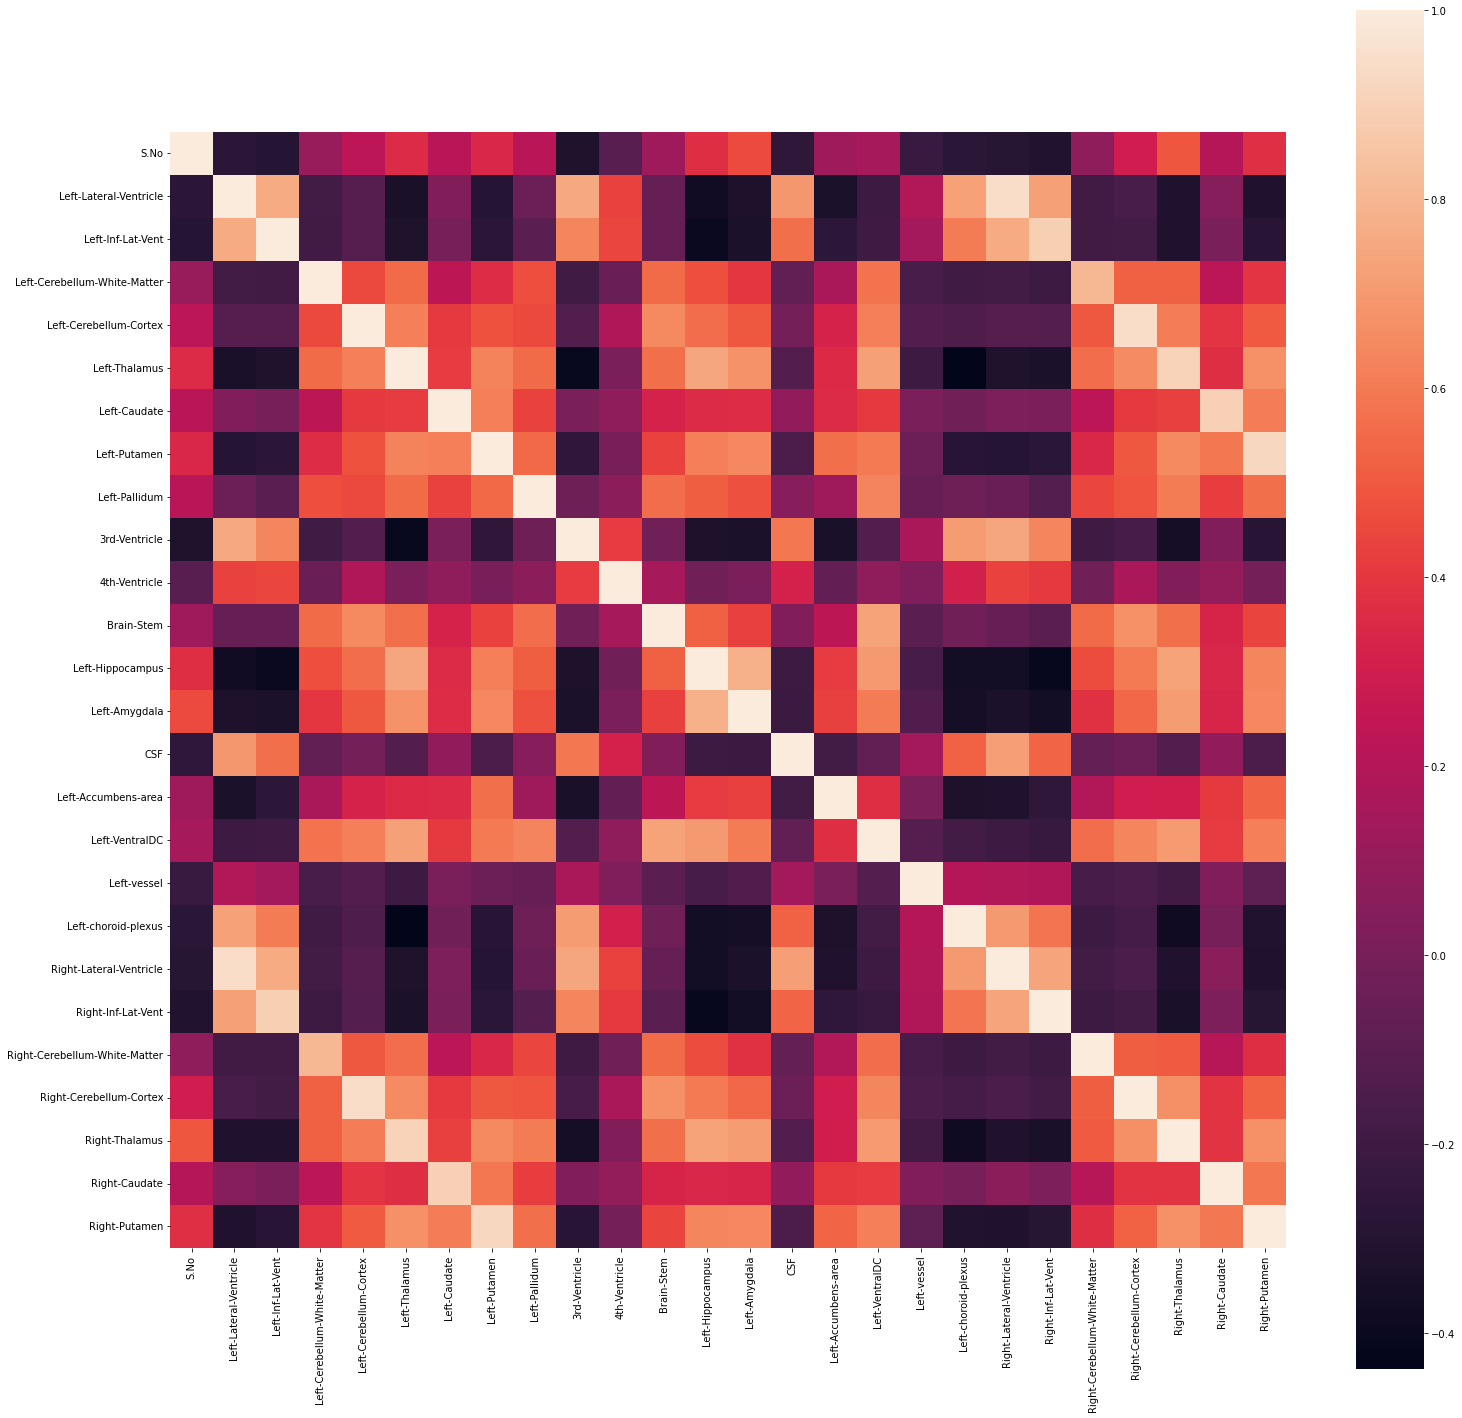

In [6]:
C_mat = data.iloc[:,:-115].corr()
fig = plt.figure(figsize = (25,25))

sb.heatmap(C_mat, square=True)
plt.show()

# Create Model

In [7]:
model = keras.models.Sequential()

model.add(keras.Input(shape=(138,)))
model.add(layers.Dense(138, activation='relu'))
model.add(layers.Dense(278, activation='relu'))
model.add(layers.Dense(278, activation='relu'))
model.add(layers.Dense(278, activation='relu'))
model.add(layers.Dense(278, activation='relu'))
model.add(layers.Dense(138, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 138)               19182     
_________________________________________________________________
dense_1 (Dense)              (None, 278)               38642     
_________________________________________________________________
dense_2 (Dense)              (None, 278)               77562     
_________________________________________________________________
dense_3 (Dense)              (None, 278)               77562     
_________________________________________________________________
dense_4 (Dense)              (None, 278)               77562     
_________________________________________________________________
dense_5 (Dense)              (None, 138)               38502     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

2022-04-10 10:28:11.134389: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-10 10:28:11.134721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-10 10:28:11.135197: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Training

In [8]:
# Split out train data, 80%, and the rest, 20%
X_train, X_rest, Y_train, Y_rest = train_test_split(data_features, data['Age'], test_size=0.20, random_state=33)
# Spit out validate data, 15% (of total, 75% of X_rest), and test, 5% (of total, 25% of rest)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_rest, Y_rest, test_size=0.25, random_state=37)

training = model.fit(X_train, Y_train, batch_size=256, verbose=1, epochs=2000, validation_data=(X_validate, Y_validate))

score = model.evaluate(X_validate, Y_validate, verbose=0, batch_size=32)

print(score)
print("Validate mean_absolute_error:", score[0])
print("Validate accuracy:", score[1])

2022-04-10 10:28:13.131301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-10 10:28:13.150608: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/2000
14/14 [==============================] - 2s 80ms/step - loss: 55560.0706 - mean_absolute_error: 55560.0706 - val_loss: 24483.8828 - val_mean_absolute_error: 24483.8828
Epoch 2/2000
14/14 [==============================] - 0s 31ms/step - loss: 19638.6997 - mean_absolute_error: 19638.6997 - val_loss: 14526.3311 - val_mean_absolute_error: 14526.3311
Epoch 3/2000
14/14 [==============================] - 1s 37ms/step - loss: 5599.4902 - mean_absolute_error: 5599.4902 - val_loss: 309.2837 - val_mean_absolute_error: 309.2837
Epoch 4/2000
14/14 [==============================] - 1s 57ms/step - loss: 1309.6320 - mean_absolute_error: 1309.6320 - val_loss: 337.3785 - val_mean_absolute_error: 337.3785
Epoch 5/2000
14/14 [==============================] - 1s 35ms/step - loss: 1147.8481 - mean_absolute_error: 1147.8481 - val_loss: 360.4176 - val_mean_absolute_error: 360.4176
Epoch 6/2000
14/14 [==============================] - 1s 45ms/step - loss: 371.7296 - mean_absolute_error: 371.72

Epoch 49/2000
14/14 [==============================] - 0s 28ms/step - loss: 14.1636 - mean_absolute_error: 14.1636 - val_loss: 13.6551 - val_mean_absolute_error: 13.6551
Epoch 50/2000
14/14 [==============================] - 0s 34ms/step - loss: 13.4425 - mean_absolute_error: 13.4425 - val_loss: 13.3271 - val_mean_absolute_error: 13.3271
Epoch 51/2000
14/14 [==============================] - 0s 34ms/step - loss: 15.4858 - mean_absolute_error: 15.4858 - val_loss: 22.4832 - val_mean_absolute_error: 22.4832
Epoch 52/2000
14/14 [==============================] - 0s 30ms/step - loss: 15.4422 - mean_absolute_error: 15.4422 - val_loss: 17.6638 - val_mean_absolute_error: 17.6638
Epoch 53/2000
14/14 [==============================] - 1s 38ms/step - loss: 13.5761 - mean_absolute_error: 13.5761 - val_loss: 13.6082 - val_mean_absolute_error: 13.6082
Epoch 54/2000
14/14 [==============================] - 1s 41ms/step - loss: 12.4056 - mean_absolute_error: 12.4056 - val_loss: 21.8343 - val_mean_abso

14/14 [==============================] - 1s 40ms/step - loss: 13.3307 - mean_absolute_error: 13.3307 - val_loss: 14.1692 - val_mean_absolute_error: 14.1692
Epoch 98/2000
14/14 [==============================] - 1s 38ms/step - loss: 11.6757 - mean_absolute_error: 11.6757 - val_loss: 12.9941 - val_mean_absolute_error: 12.9941
Epoch 99/2000
14/14 [==============================] - 1s 41ms/step - loss: 13.5401 - mean_absolute_error: 13.5401 - val_loss: 13.2684 - val_mean_absolute_error: 13.2684
Epoch 100/2000
14/14 [==============================] - 1s 53ms/step - loss: 12.2776 - mean_absolute_error: 12.2776 - val_loss: 12.8799 - val_mean_absolute_error: 12.8799
Epoch 101/2000
14/14 [==============================] - 1s 48ms/step - loss: 14.3858 - mean_absolute_error: 14.3858 - val_loss: 15.3449 - val_mean_absolute_error: 15.3449
Epoch 102/2000
14/14 [==============================] - 0s 34ms/step - loss: 13.0322 - mean_absolute_error: 13.0322 - val_loss: 13.6814 - val_mean_absolute_error:

Epoch 145/2000
14/14 [==============================] - 1s 57ms/step - loss: 16.7640 - mean_absolute_error: 16.7640 - val_loss: 22.1651 - val_mean_absolute_error: 22.1651
Epoch 146/2000
14/14 [==============================] - 1s 48ms/step - loss: 17.2840 - mean_absolute_error: 17.2840 - val_loss: 37.4025 - val_mean_absolute_error: 37.4025
Epoch 147/2000
14/14 [==============================] - 1s 37ms/step - loss: 34.3548 - mean_absolute_error: 34.3548 - val_loss: 22.9689 - val_mean_absolute_error: 22.9689
Epoch 148/2000
14/14 [==============================] - 1s 42ms/step - loss: 147.2709 - mean_absolute_error: 147.2709 - val_loss: 693.9822 - val_mean_absolute_error: 693.9822
Epoch 149/2000
14/14 [==============================] - 1s 52ms/step - loss: 490.9384 - mean_absolute_error: 490.9384 - val_loss: 66.5683 - val_mean_absolute_error: 66.5683
Epoch 150/2000
14/14 [==============================] - 1s 41ms/step - loss: 219.7953 - mean_absolute_error: 219.7953 - val_loss: 136.3901 

Epoch 193/2000
14/14 [==============================] - 1s 72ms/step - loss: 11.1873 - mean_absolute_error: 11.1873 - val_loss: 12.3897 - val_mean_absolute_error: 12.3897
Epoch 194/2000
14/14 [==============================] - 1s 63ms/step - loss: 11.3952 - mean_absolute_error: 11.3952 - val_loss: 12.7239 - val_mean_absolute_error: 12.7239
Epoch 195/2000
14/14 [==============================] - 1s 49ms/step - loss: 11.2821 - mean_absolute_error: 11.2821 - val_loss: 17.5256 - val_mean_absolute_error: 17.5256
Epoch 196/2000
14/14 [==============================] - 1s 41ms/step - loss: 14.3149 - mean_absolute_error: 14.3149 - val_loss: 15.4585 - val_mean_absolute_error: 15.4585
Epoch 197/2000
14/14 [==============================] - 1s 63ms/step - loss: 12.4060 - mean_absolute_error: 12.4060 - val_loss: 15.8075 - val_mean_absolute_error: 15.8075
Epoch 198/2000
14/14 [==============================] - 1s 70ms/step - loss: 12.2590 - mean_absolute_error: 12.2590 - val_loss: 15.6265 - val_mea

Epoch 241/2000
14/14 [==============================] - 2s 125ms/step - loss: 11.2718 - mean_absolute_error: 11.2718 - val_loss: 11.8959 - val_mean_absolute_error: 11.8959
Epoch 242/2000
14/14 [==============================] - 1s 52ms/step - loss: 10.4959 - mean_absolute_error: 10.4959 - val_loss: 13.6484 - val_mean_absolute_error: 13.6484
Epoch 243/2000
14/14 [==============================] - 1s 67ms/step - loss: 11.1969 - mean_absolute_error: 11.1969 - val_loss: 13.5767 - val_mean_absolute_error: 13.5767
Epoch 244/2000
14/14 [==============================] - 1s 82ms/step - loss: 11.3426 - mean_absolute_error: 11.3426 - val_loss: 11.8720 - val_mean_absolute_error: 11.8720
Epoch 245/2000
14/14 [==============================] - 2s 127ms/step - loss: 10.4716 - mean_absolute_error: 10.4716 - val_loss: 11.5075 - val_mean_absolute_error: 11.5075
Epoch 246/2000
14/14 [==============================] - 2s 126ms/step - loss: 10.3954 - mean_absolute_error: 10.3954 - val_loss: 11.4719 - val_

Epoch 289/2000
14/14 [==============================] - 1s 84ms/step - loss: 10.9554 - mean_absolute_error: 10.9554 - val_loss: 12.1629 - val_mean_absolute_error: 12.1629
Epoch 290/2000
14/14 [==============================] - 1s 58ms/step - loss: 10.6639 - mean_absolute_error: 10.6639 - val_loss: 13.3142 - val_mean_absolute_error: 13.3142
Epoch 291/2000
14/14 [==============================] - 1s 74ms/step - loss: 11.5490 - mean_absolute_error: 11.5490 - val_loss: 11.8972 - val_mean_absolute_error: 11.8972
Epoch 292/2000
14/14 [==============================] - 1s 63ms/step - loss: 11.0640 - mean_absolute_error: 11.0640 - val_loss: 11.4079 - val_mean_absolute_error: 11.4079
Epoch 293/2000
14/14 [==============================] - 1s 67ms/step - loss: 10.7921 - mean_absolute_error: 10.7921 - val_loss: 14.9267 - val_mean_absolute_error: 14.9267
Epoch 294/2000
14/14 [==============================] - 1s 58ms/step - loss: 11.5365 - mean_absolute_error: 11.5365 - val_loss: 13.7963 - val_mea

Epoch 337/2000
14/14 [==============================] - 1s 98ms/step - loss: 12.0324 - mean_absolute_error: 12.0324 - val_loss: 12.7254 - val_mean_absolute_error: 12.7254
Epoch 338/2000
14/14 [==============================] - 1s 65ms/step - loss: 11.1702 - mean_absolute_error: 11.1702 - val_loss: 11.8039 - val_mean_absolute_error: 11.8039
Epoch 339/2000
14/14 [==============================] - 1s 62ms/step - loss: 10.7337 - mean_absolute_error: 10.7337 - val_loss: 13.2916 - val_mean_absolute_error: 13.2916
Epoch 340/2000
14/14 [==============================] - 1s 68ms/step - loss: 11.2724 - mean_absolute_error: 11.2724 - val_loss: 11.7092 - val_mean_absolute_error: 11.7092
Epoch 341/2000
14/14 [==============================] - 1s 101ms/step - loss: 10.6712 - mean_absolute_error: 10.6712 - val_loss: 15.9645 - val_mean_absolute_error: 15.9645
Epoch 342/2000
14/14 [==============================] - 1s 96ms/step - loss: 12.6759 - mean_absolute_error: 12.6759 - val_loss: 12.7533 - val_me

Epoch 385/2000
14/14 [==============================] - 1s 62ms/step - loss: 12.1496 - mean_absolute_error: 12.1496 - val_loss: 14.6326 - val_mean_absolute_error: 14.6326
Epoch 386/2000
14/14 [==============================] - 1s 41ms/step - loss: 12.7122 - mean_absolute_error: 12.7122 - val_loss: 15.2779 - val_mean_absolute_error: 15.2779
Epoch 387/2000
14/14 [==============================] - 1s 61ms/step - loss: 12.8521 - mean_absolute_error: 12.8521 - val_loss: 15.3043 - val_mean_absolute_error: 15.3043
Epoch 388/2000
14/14 [==============================] - 1s 73ms/step - loss: 12.2338 - mean_absolute_error: 12.2338 - val_loss: 12.7024 - val_mean_absolute_error: 12.7024
Epoch 389/2000
14/14 [==============================] - 1s 75ms/step - loss: 11.2243 - mean_absolute_error: 11.2243 - val_loss: 11.9237 - val_mean_absolute_error: 11.9237
Epoch 390/2000
14/14 [==============================] - 1s 99ms/step - loss: 10.8284 - mean_absolute_error: 10.8284 - val_loss: 12.9070 - val_mea

Epoch 433/2000
14/14 [==============================] - 1s 52ms/step - loss: 11.3174 - mean_absolute_error: 11.3174 - val_loss: 11.5006 - val_mean_absolute_error: 11.5006
Epoch 434/2000
14/14 [==============================] - 1s 42ms/step - loss: 10.4502 - mean_absolute_error: 10.4502 - val_loss: 11.6165 - val_mean_absolute_error: 11.6165
Epoch 435/2000
14/14 [==============================] - 1s 56ms/step - loss: 11.2273 - mean_absolute_error: 11.2273 - val_loss: 11.7888 - val_mean_absolute_error: 11.7888
Epoch 436/2000
14/14 [==============================] - 1s 46ms/step - loss: 10.6872 - mean_absolute_error: 10.6872 - val_loss: 12.0504 - val_mean_absolute_error: 12.0504
Epoch 437/2000
14/14 [==============================] - 1s 54ms/step - loss: 11.8565 - mean_absolute_error: 11.8565 - val_loss: 16.7308 - val_mean_absolute_error: 16.7308
Epoch 438/2000
14/14 [==============================] - 1s 47ms/step - loss: 12.7527 - mean_absolute_error: 12.7527 - val_loss: 12.2096 - val_mea

Epoch 481/2000
14/14 [==============================] - 1s 35ms/step - loss: 13.1273 - mean_absolute_error: 13.1273 - val_loss: 12.0371 - val_mean_absolute_error: 12.0371
Epoch 482/2000
14/14 [==============================] - 1s 53ms/step - loss: 11.2447 - mean_absolute_error: 11.2447 - val_loss: 12.0599 - val_mean_absolute_error: 12.0599
Epoch 483/2000
14/14 [==============================] - 1s 54ms/step - loss: 10.8799 - mean_absolute_error: 10.8799 - val_loss: 13.2623 - val_mean_absolute_error: 13.2623
Epoch 484/2000
14/14 [==============================] - 1s 51ms/step - loss: 10.9835 - mean_absolute_error: 10.9835 - val_loss: 12.2785 - val_mean_absolute_error: 12.2785
Epoch 485/2000
14/14 [==============================] - 1s 45ms/step - loss: 10.2126 - mean_absolute_error: 10.2126 - val_loss: 11.2551 - val_mean_absolute_error: 11.2551
Epoch 486/2000
14/14 [==============================] - 1s 39ms/step - loss: 10.3301 - mean_absolute_error: 10.3301 - val_loss: 11.4558 - val_mea

Epoch 529/2000
14/14 [==============================] - 1s 52ms/step - loss: 11.0593 - mean_absolute_error: 11.0593 - val_loss: 13.7275 - val_mean_absolute_error: 13.7275
Epoch 530/2000
14/14 [==============================] - 0s 25ms/step - loss: 11.2943 - mean_absolute_error: 11.2943 - val_loss: 11.6034 - val_mean_absolute_error: 11.6034
Epoch 531/2000
14/14 [==============================] - 1s 44ms/step - loss: 10.6147 - mean_absolute_error: 10.6147 - val_loss: 11.5553 - val_mean_absolute_error: 11.5553
Epoch 532/2000
14/14 [==============================] - 1s 41ms/step - loss: 10.2275 - mean_absolute_error: 10.2275 - val_loss: 11.2423 - val_mean_absolute_error: 11.2423
Epoch 533/2000
14/14 [==============================] - 1s 38ms/step - loss: 10.6046 - mean_absolute_error: 10.6046 - val_loss: 10.7698 - val_mean_absolute_error: 10.7698
Epoch 534/2000
14/14 [==============================] - 1s 42ms/step - loss: 9.7820 - mean_absolute_error: 9.7820 - val_loss: 10.8359 - val_mean_

Epoch 577/2000
14/14 [==============================] - 1s 39ms/step - loss: 10.9929 - mean_absolute_error: 10.9929 - val_loss: 11.7642 - val_mean_absolute_error: 11.7642
Epoch 578/2000
14/14 [==============================] - 1s 42ms/step - loss: 11.1389 - mean_absolute_error: 11.1389 - val_loss: 12.9860 - val_mean_absolute_error: 12.9860
Epoch 579/2000
14/14 [==============================] - 0s 31ms/step - loss: 11.3814 - mean_absolute_error: 11.3814 - val_loss: 12.0468 - val_mean_absolute_error: 12.0468
Epoch 580/2000
14/14 [==============================] - 1s 42ms/step - loss: 10.4806 - mean_absolute_error: 10.4806 - val_loss: 11.7678 - val_mean_absolute_error: 11.7678
Epoch 581/2000
14/14 [==============================] - 0s 29ms/step - loss: 10.5614 - mean_absolute_error: 10.5614 - val_loss: 11.5154 - val_mean_absolute_error: 11.5154
Epoch 582/2000
14/14 [==============================] - 1s 51ms/step - loss: 10.1552 - mean_absolute_error: 10.1552 - val_loss: 12.1167 - val_mea

Epoch 625/2000
14/14 [==============================] - 0s 27ms/step - loss: 9.9963 - mean_absolute_error: 9.9963 - val_loss: 10.8162 - val_mean_absolute_error: 10.8162
Epoch 626/2000
14/14 [==============================] - 1s 50ms/step - loss: 9.6934 - mean_absolute_error: 9.6934 - val_loss: 10.9462 - val_mean_absolute_error: 10.9462
Epoch 627/2000
14/14 [==============================] - 1s 54ms/step - loss: 9.9093 - mean_absolute_error: 9.9093 - val_loss: 10.6721 - val_mean_absolute_error: 10.6721
Epoch 628/2000
14/14 [==============================] - 1s 55ms/step - loss: 9.5568 - mean_absolute_error: 9.5568 - val_loss: 11.7735 - val_mean_absolute_error: 11.7735
Epoch 629/2000
14/14 [==============================] - 1s 82ms/step - loss: 10.2593 - mean_absolute_error: 10.2593 - val_loss: 11.8368 - val_mean_absolute_error: 11.8368
Epoch 630/2000
14/14 [==============================] - 1s 109ms/step - loss: 10.7377 - mean_absolute_error: 10.7377 - val_loss: 11.3314 - val_mean_absol

14/14 [==============================] - 1s 63ms/step - loss: 9.6444 - mean_absolute_error: 9.6444 - val_loss: 10.5949 - val_mean_absolute_error: 10.5949
Epoch 674/2000
14/14 [==============================] - 1s 76ms/step - loss: 9.2019 - mean_absolute_error: 9.2019 - val_loss: 13.0107 - val_mean_absolute_error: 13.0107
Epoch 675/2000
14/14 [==============================] - 1s 48ms/step - loss: 11.1346 - mean_absolute_error: 11.1346 - val_loss: 11.5353 - val_mean_absolute_error: 11.5353
Epoch 676/2000
14/14 [==============================] - 1s 49ms/step - loss: 10.4102 - mean_absolute_error: 10.4102 - val_loss: 12.1631 - val_mean_absolute_error: 12.1631
Epoch 677/2000
14/14 [==============================] - 1s 57ms/step - loss: 10.3807 - mean_absolute_error: 10.3807 - val_loss: 10.9519 - val_mean_absolute_error: 10.9519
Epoch 678/2000
14/14 [==============================] - 1s 83ms/step - loss: 9.7436 - mean_absolute_error: 9.7436 - val_loss: 10.4262 - val_mean_absolute_error: 10.

14/14 [==============================] - 0s 35ms/step - loss: 10.2056 - mean_absolute_error: 10.2056 - val_loss: 10.6527 - val_mean_absolute_error: 10.6527
Epoch 722/2000
14/14 [==============================] - 1s 80ms/step - loss: 10.0537 - mean_absolute_error: 10.0537 - val_loss: 10.7864 - val_mean_absolute_error: 10.7864
Epoch 723/2000
14/14 [==============================] - 1s 58ms/step - loss: 9.3833 - mean_absolute_error: 9.3833 - val_loss: 10.5062 - val_mean_absolute_error: 10.5062
Epoch 724/2000
14/14 [==============================] - 1s 50ms/step - loss: 9.0521 - mean_absolute_error: 9.0521 - val_loss: 10.5578 - val_mean_absolute_error: 10.5578
Epoch 725/2000
14/14 [==============================] - 1s 42ms/step - loss: 9.3405 - mean_absolute_error: 9.3405 - val_loss: 10.9320 - val_mean_absolute_error: 10.9320
Epoch 726/2000
14/14 [==============================] - 1s 42ms/step - loss: 9.4949 - mean_absolute_error: 9.4949 - val_loss: 10.6106 - val_mean_absolute_error: 10.61

14/14 [==============================] - 0s 34ms/step - loss: 9.4996 - mean_absolute_error: 9.4996 - val_loss: 10.2140 - val_mean_absolute_error: 10.2140
Epoch 770/2000
14/14 [==============================] - 1s 75ms/step - loss: 9.4620 - mean_absolute_error: 9.4620 - val_loss: 10.4453 - val_mean_absolute_error: 10.4453
Epoch 771/2000
14/14 [==============================] - 1s 38ms/step - loss: 9.4815 - mean_absolute_error: 9.4815 - val_loss: 11.2678 - val_mean_absolute_error: 11.2678
Epoch 772/2000
14/14 [==============================] - 1s 48ms/step - loss: 10.0010 - mean_absolute_error: 10.0010 - val_loss: 11.3700 - val_mean_absolute_error: 11.3700
Epoch 773/2000
14/14 [==============================] - 1s 43ms/step - loss: 10.7485 - mean_absolute_error: 10.7485 - val_loss: 12.1933 - val_mean_absolute_error: 12.1933
Epoch 774/2000
14/14 [==============================] - 1s 40ms/step - loss: 10.6315 - mean_absolute_error: 10.6315 - val_loss: 11.1590 - val_mean_absolute_error: 11.

14/14 [==============================] - 0s 36ms/step - loss: 9.0290 - mean_absolute_error: 9.0290 - val_loss: 10.1775 - val_mean_absolute_error: 10.1775
Epoch 818/2000
14/14 [==============================] - 1s 51ms/step - loss: 8.9852 - mean_absolute_error: 8.9852 - val_loss: 9.6970 - val_mean_absolute_error: 9.6970
Epoch 819/2000
14/14 [==============================] - 1s 36ms/step - loss: 8.4863 - mean_absolute_error: 8.4863 - val_loss: 11.8571 - val_mean_absolute_error: 11.8571
Epoch 820/2000
14/14 [==============================] - 1s 46ms/step - loss: 9.8891 - mean_absolute_error: 9.8891 - val_loss: 12.2834 - val_mean_absolute_error: 12.2834
Epoch 821/2000
14/14 [==============================] - 1s 48ms/step - loss: 9.9709 - mean_absolute_error: 9.9709 - val_loss: 10.5892 - val_mean_absolute_error: 10.5892
Epoch 822/2000
14/14 [==============================] - 1s 47ms/step - loss: 8.6130 - mean_absolute_error: 8.6130 - val_loss: 10.5600 - val_mean_absolute_error: 10.5600
Epo

Epoch 866/2000
14/14 [==============================] - 1s 43ms/step - loss: 9.6747 - mean_absolute_error: 9.6747 - val_loss: 10.0960 - val_mean_absolute_error: 10.0960
Epoch 867/2000
14/14 [==============================] - 1s 40ms/step - loss: 8.4270 - mean_absolute_error: 8.4270 - val_loss: 9.8535 - val_mean_absolute_error: 9.8535
Epoch 868/2000
14/14 [==============================] - 1s 45ms/step - loss: 8.5726 - mean_absolute_error: 8.5726 - val_loss: 10.0352 - val_mean_absolute_error: 10.0352
Epoch 869/2000
14/14 [==============================] - 1s 53ms/step - loss: 8.6850 - mean_absolute_error: 8.6850 - val_loss: 11.2761 - val_mean_absolute_error: 11.2761
Epoch 870/2000
14/14 [==============================] - 1s 51ms/step - loss: 9.3390 - mean_absolute_error: 9.3390 - val_loss: 10.5190 - val_mean_absolute_error: 10.5190
Epoch 871/2000
14/14 [==============================] - 1s 64ms/step - loss: 9.3096 - mean_absolute_error: 9.3096 - val_loss: 9.8640 - val_mean_absolute_erro

Epoch 915/2000
14/14 [==============================] - 0s 32ms/step - loss: 8.6094 - mean_absolute_error: 8.6094 - val_loss: 9.8842 - val_mean_absolute_error: 9.8842
Epoch 916/2000
14/14 [==============================] - 1s 42ms/step - loss: 8.2954 - mean_absolute_error: 8.2954 - val_loss: 10.9513 - val_mean_absolute_error: 10.9513
Epoch 917/2000
14/14 [==============================] - 1s 51ms/step - loss: 10.2044 - mean_absolute_error: 10.2044 - val_loss: 9.8590 - val_mean_absolute_error: 9.8590
Epoch 918/2000
14/14 [==============================] - 1s 41ms/step - loss: 8.7894 - mean_absolute_error: 8.7894 - val_loss: 9.3888 - val_mean_absolute_error: 9.3888
Epoch 919/2000
14/14 [==============================] - 1s 56ms/step - loss: 8.0710 - mean_absolute_error: 8.0710 - val_loss: 11.2661 - val_mean_absolute_error: 11.2661
Epoch 920/2000
14/14 [==============================] - 1s 92ms/step - loss: 9.8442 - mean_absolute_error: 9.8442 - val_loss: 10.7213 - val_mean_absolute_error

Epoch 964/2000
14/14 [==============================] - 1s 99ms/step - loss: 9.1962 - mean_absolute_error: 9.1962 - val_loss: 9.6251 - val_mean_absolute_error: 9.6251
Epoch 965/2000
14/14 [==============================] - 0s 36ms/step - loss: 8.1871 - mean_absolute_error: 8.1871 - val_loss: 9.5765 - val_mean_absolute_error: 9.5765
Epoch 966/2000
14/14 [==============================] - 1s 39ms/step - loss: 8.2070 - mean_absolute_error: 8.2070 - val_loss: 10.4096 - val_mean_absolute_error: 10.4096
Epoch 967/2000
14/14 [==============================] - 0s 36ms/step - loss: 8.4929 - mean_absolute_error: 8.4929 - val_loss: 9.6386 - val_mean_absolute_error: 9.6386
Epoch 968/2000
14/14 [==============================] - 1s 52ms/step - loss: 8.4075 - mean_absolute_error: 8.4075 - val_loss: 9.5198 - val_mean_absolute_error: 9.5198
Epoch 969/2000
14/14 [==============================] - 1s 62ms/step - loss: 8.3554 - mean_absolute_error: 8.3554 - val_loss: 9.3717 - val_mean_absolute_error: 9.3

Epoch 1013/2000
14/14 [==============================] - 2s 117ms/step - loss: 8.5108 - mean_absolute_error: 8.5108 - val_loss: 9.6034 - val_mean_absolute_error: 9.6034
Epoch 1014/2000
14/14 [==============================] - 2s 110ms/step - loss: 7.9318 - mean_absolute_error: 7.9318 - val_loss: 9.2673 - val_mean_absolute_error: 9.2673
Epoch 1015/2000
14/14 [==============================] - 1s 55ms/step - loss: 7.9004 - mean_absolute_error: 7.9004 - val_loss: 9.2391 - val_mean_absolute_error: 9.2391
Epoch 1016/2000
14/14 [==============================] - 1s 55ms/step - loss: 7.6616 - mean_absolute_error: 7.6616 - val_loss: 10.9676 - val_mean_absolute_error: 10.9676
Epoch 1017/2000
14/14 [==============================] - 1s 106ms/step - loss: 8.7766 - mean_absolute_error: 8.7766 - val_loss: 9.3890 - val_mean_absolute_error: 9.3890
Epoch 1018/2000
14/14 [==============================] - 1s 88ms/step - loss: 8.6769 - mean_absolute_error: 8.6769 - val_loss: 10.9221 - val_mean_absolute_

14/14 [==============================] - 3s 192ms/step - loss: 9.2612 - mean_absolute_error: 9.2612 - val_loss: 10.4386 - val_mean_absolute_error: 10.4386
Epoch 1062/2000
14/14 [==============================] - 1s 104ms/step - loss: 8.9088 - mean_absolute_error: 8.9088 - val_loss: 10.3222 - val_mean_absolute_error: 10.3222
Epoch 1063/2000
14/14 [==============================] - 1s 86ms/step - loss: 8.3283 - mean_absolute_error: 8.3283 - val_loss: 8.8989 - val_mean_absolute_error: 8.8989
Epoch 1064/2000
14/14 [==============================] - 2s 126ms/step - loss: 8.3272 - mean_absolute_error: 8.3272 - val_loss: 9.3180 - val_mean_absolute_error: 9.3180
Epoch 1065/2000
14/14 [==============================] - 1s 66ms/step - loss: 7.9090 - mean_absolute_error: 7.9090 - val_loss: 8.9088 - val_mean_absolute_error: 8.9088
Epoch 1066/2000
14/14 [==============================] - 1s 50ms/step - loss: 8.1006 - mean_absolute_error: 8.1006 - val_loss: 10.1113 - val_mean_absolute_error: 10.1113

14/14 [==============================] - 2s 122ms/step - loss: 7.9767 - mean_absolute_error: 7.9767 - val_loss: 9.2505 - val_mean_absolute_error: 9.2505
Epoch 1110/2000
14/14 [==============================] - 0s 35ms/step - loss: 7.5634 - mean_absolute_error: 7.5634 - val_loss: 9.9695 - val_mean_absolute_error: 9.9695
Epoch 1111/2000
14/14 [==============================] - 1s 41ms/step - loss: 8.0491 - mean_absolute_error: 8.0491 - val_loss: 8.9410 - val_mean_absolute_error: 8.9410
Epoch 1112/2000
14/14 [==============================] - 1s 44ms/step - loss: 7.5647 - mean_absolute_error: 7.5647 - val_loss: 9.0986 - val_mean_absolute_error: 9.0986
Epoch 1113/2000
14/14 [==============================] - 1s 48ms/step - loss: 7.9361 - mean_absolute_error: 7.9361 - val_loss: 9.4025 - val_mean_absolute_error: 9.4025
Epoch 1114/2000
14/14 [==============================] - 1s 65ms/step - loss: 8.7257 - mean_absolute_error: 8.7257 - val_loss: 15.0168 - val_mean_absolute_error: 15.0168
Epoch

Epoch 1158/2000
14/14 [==============================] - 1s 67ms/step - loss: 7.8884 - mean_absolute_error: 7.8884 - val_loss: 8.8572 - val_mean_absolute_error: 8.8572
Epoch 1159/2000
14/14 [==============================] - 1s 62ms/step - loss: 7.5168 - mean_absolute_error: 7.5168 - val_loss: 8.8779 - val_mean_absolute_error: 8.8779
Epoch 1160/2000
14/14 [==============================] - 1s 68ms/step - loss: 7.8691 - mean_absolute_error: 7.8691 - val_loss: 9.1924 - val_mean_absolute_error: 9.1924
Epoch 1161/2000
14/14 [==============================] - 1s 82ms/step - loss: 7.6788 - mean_absolute_error: 7.6788 - val_loss: 8.6250 - val_mean_absolute_error: 8.6250
Epoch 1162/2000
14/14 [==============================] - 2s 103ms/step - loss: 7.6224 - mean_absolute_error: 7.6224 - val_loss: 8.9369 - val_mean_absolute_error: 8.9369
Epoch 1163/2000
14/14 [==============================] - 1s 96ms/step - loss: 7.4859 - mean_absolute_error: 7.4859 - val_loss: 9.5440 - val_mean_absolute_error

14/14 [==============================] - 2s 144ms/step - loss: 7.5655 - mean_absolute_error: 7.5655 - val_loss: 9.3702 - val_mean_absolute_error: 9.3702
Epoch 1207/2000
14/14 [==============================] - 1s 75ms/step - loss: 8.3896 - mean_absolute_error: 8.3896 - val_loss: 8.6504 - val_mean_absolute_error: 8.6504
Epoch 1208/2000
14/14 [==============================] - 1s 63ms/step - loss: 7.3466 - mean_absolute_error: 7.3466 - val_loss: 8.6706 - val_mean_absolute_error: 8.6706
Epoch 1209/2000
14/14 [==============================] - 1s 43ms/step - loss: 8.0381 - mean_absolute_error: 8.0381 - val_loss: 9.4005 - val_mean_absolute_error: 9.4005
Epoch 1210/2000
14/14 [==============================] - 1s 56ms/step - loss: 7.5901 - mean_absolute_error: 7.5901 - val_loss: 8.7104 - val_mean_absolute_error: 8.7104
Epoch 1211/2000
14/14 [==============================] - 1s 65ms/step - loss: 7.8511 - mean_absolute_error: 7.8511 - val_loss: 9.1870 - val_mean_absolute_error: 9.1870
Epoch 1

Epoch 1255/2000
14/14 [==============================] - 1s 71ms/step - loss: 8.1121 - mean_absolute_error: 8.1121 - val_loss: 9.9260 - val_mean_absolute_error: 9.9260
Epoch 1256/2000
14/14 [==============================] - 1s 76ms/step - loss: 8.1468 - mean_absolute_error: 8.1468 - val_loss: 9.1080 - val_mean_absolute_error: 9.1080
Epoch 1257/2000
14/14 [==============================] - 1s 101ms/step - loss: 7.3984 - mean_absolute_error: 7.3984 - val_loss: 8.6333 - val_mean_absolute_error: 8.6333
Epoch 1258/2000
14/14 [==============================] - 1s 80ms/step - loss: 7.3257 - mean_absolute_error: 7.3257 - val_loss: 8.9164 - val_mean_absolute_error: 8.9164
Epoch 1259/2000
14/14 [==============================] - 1s 63ms/step - loss: 7.5555 - mean_absolute_error: 7.5555 - val_loss: 8.7301 - val_mean_absolute_error: 8.7301
Epoch 1260/2000
14/14 [==============================] - 1s 61ms/step - loss: 7.2882 - mean_absolute_error: 7.2882 - val_loss: 8.8426 - val_mean_absolute_error

Epoch 1304/2000
14/14 [==============================] - 2s 121ms/step - loss: 7.2266 - mean_absolute_error: 7.2266 - val_loss: 8.5192 - val_mean_absolute_error: 8.5192
Epoch 1305/2000
14/14 [==============================] - 1s 72ms/step - loss: 7.0898 - mean_absolute_error: 7.0898 - val_loss: 10.3489 - val_mean_absolute_error: 10.3489
Epoch 1306/2000
14/14 [==============================] - 1s 60ms/step - loss: 7.6541 - mean_absolute_error: 7.6541 - val_loss: 8.8429 - val_mean_absolute_error: 8.8429
Epoch 1307/2000
14/14 [==============================] - 1s 76ms/step - loss: 7.7910 - mean_absolute_error: 7.7910 - val_loss: 10.7683 - val_mean_absolute_error: 10.7683
Epoch 1308/2000
14/14 [==============================] - 1s 77ms/step - loss: 8.3374 - mean_absolute_error: 8.3374 - val_loss: 8.8199 - val_mean_absolute_error: 8.8199
Epoch 1309/2000
14/14 [==============================] - 1s 52ms/step - loss: 7.9592 - mean_absolute_error: 7.9592 - val_loss: 9.0594 - val_mean_absolute_e

Epoch 1353/2000
14/14 [==============================] - 0s 30ms/step - loss: 7.4186 - mean_absolute_error: 7.4186 - val_loss: 8.1855 - val_mean_absolute_error: 8.1855
Epoch 1354/2000
14/14 [==============================] - 1s 38ms/step - loss: 6.5485 - mean_absolute_error: 6.5485 - val_loss: 9.4892 - val_mean_absolute_error: 9.4892
Epoch 1355/2000
14/14 [==============================] - 0s 26ms/step - loss: 8.1071 - mean_absolute_error: 8.1071 - val_loss: 8.6369 - val_mean_absolute_error: 8.6369
Epoch 1356/2000
14/14 [==============================] - 1s 41ms/step - loss: 6.7465 - mean_absolute_error: 6.7465 - val_loss: 9.1046 - val_mean_absolute_error: 9.1046
Epoch 1357/2000
14/14 [==============================] - 0s 32ms/step - loss: 7.2161 - mean_absolute_error: 7.2161 - val_loss: 8.5694 - val_mean_absolute_error: 8.5694
Epoch 1358/2000
14/14 [==============================] - 1s 47ms/step - loss: 6.8775 - mean_absolute_error: 6.8775 - val_loss: 8.5519 - val_mean_absolute_error:

Epoch 1402/2000
14/14 [==============================] - 1s 61ms/step - loss: 6.5571 - mean_absolute_error: 6.5571 - val_loss: 8.2018 - val_mean_absolute_error: 8.2018
Epoch 1403/2000
14/14 [==============================] - 1s 63ms/step - loss: 7.5584 - mean_absolute_error: 7.5584 - val_loss: 8.2955 - val_mean_absolute_error: 8.2955
Epoch 1404/2000
14/14 [==============================] - 1s 49ms/step - loss: 6.7378 - mean_absolute_error: 6.7378 - val_loss: 9.0217 - val_mean_absolute_error: 9.0217
Epoch 1405/2000
14/14 [==============================] - 1s 61ms/step - loss: 7.3850 - mean_absolute_error: 7.3850 - val_loss: 8.0366 - val_mean_absolute_error: 8.0366
Epoch 1406/2000
14/14 [==============================] - 1s 85ms/step - loss: 7.0246 - mean_absolute_error: 7.0246 - val_loss: 8.2786 - val_mean_absolute_error: 8.2786
Epoch 1407/2000
14/14 [==============================] - 1s 61ms/step - loss: 7.1166 - mean_absolute_error: 7.1166 - val_loss: 8.5685 - val_mean_absolute_error:

Epoch 1451/2000
14/14 [==============================] - 1s 60ms/step - loss: 6.5030 - mean_absolute_error: 6.5030 - val_loss: 9.8923 - val_mean_absolute_error: 9.8923
Epoch 1452/2000
14/14 [==============================] - 1s 58ms/step - loss: 8.2006 - mean_absolute_error: 8.2006 - val_loss: 8.7918 - val_mean_absolute_error: 8.7918
Epoch 1453/2000
14/14 [==============================] - 1s 59ms/step - loss: 7.8224 - mean_absolute_error: 7.8224 - val_loss: 8.1463 - val_mean_absolute_error: 8.1463
Epoch 1454/2000
14/14 [==============================] - 0s 35ms/step - loss: 6.3133 - mean_absolute_error: 6.3133 - val_loss: 7.6960 - val_mean_absolute_error: 7.6960
Epoch 1455/2000
14/14 [==============================] - 1s 62ms/step - loss: 6.1008 - mean_absolute_error: 6.1008 - val_loss: 7.9709 - val_mean_absolute_error: 7.9709
Epoch 1456/2000
14/14 [==============================] - 1s 71ms/step - loss: 6.3430 - mean_absolute_error: 6.3430 - val_loss: 8.7556 - val_mean_absolute_error:

Epoch 1500/2000
14/14 [==============================] - 1s 49ms/step - loss: 6.2542 - mean_absolute_error: 6.2542 - val_loss: 7.9934 - val_mean_absolute_error: 7.9934
Epoch 1501/2000
14/14 [==============================] - 0s 34ms/step - loss: 6.4511 - mean_absolute_error: 6.4511 - val_loss: 8.3347 - val_mean_absolute_error: 8.3347
Epoch 1502/2000
14/14 [==============================] - 1s 41ms/step - loss: 6.3219 - mean_absolute_error: 6.3219 - val_loss: 7.8166 - val_mean_absolute_error: 7.8166
Epoch 1503/2000
14/14 [==============================] - 1s 43ms/step - loss: 6.1655 - mean_absolute_error: 6.1655 - val_loss: 7.5753 - val_mean_absolute_error: 7.5753
Epoch 1504/2000
14/14 [==============================] - 1s 41ms/step - loss: 6.0588 - mean_absolute_error: 6.0588 - val_loss: 9.4021 - val_mean_absolute_error: 9.4021
Epoch 1505/2000
14/14 [==============================] - 1s 56ms/step - loss: 7.2530 - mean_absolute_error: 7.2530 - val_loss: 7.8252 - val_mean_absolute_error:

Epoch 1549/2000
14/14 [==============================] - 1s 81ms/step - loss: 6.0852 - mean_absolute_error: 6.0852 - val_loss: 7.5704 - val_mean_absolute_error: 7.5704
Epoch 1550/2000
14/14 [==============================] - 1s 77ms/step - loss: 5.7292 - mean_absolute_error: 5.7292 - val_loss: 7.8189 - val_mean_absolute_error: 7.8189
Epoch 1551/2000
14/14 [==============================] - 1s 51ms/step - loss: 6.2998 - mean_absolute_error: 6.2998 - val_loss: 7.5991 - val_mean_absolute_error: 7.5991
Epoch 1552/2000
14/14 [==============================] - 1s 41ms/step - loss: 5.8555 - mean_absolute_error: 5.8555 - val_loss: 7.8688 - val_mean_absolute_error: 7.8688
Epoch 1553/2000
14/14 [==============================] - 1s 40ms/step - loss: 6.1491 - mean_absolute_error: 6.1491 - val_loss: 8.2497 - val_mean_absolute_error: 8.2497
Epoch 1554/2000
14/14 [==============================] - 1s 44ms/step - loss: 6.7977 - mean_absolute_error: 6.7977 - val_loss: 8.3092 - val_mean_absolute_error:

Epoch 1598/2000
14/14 [==============================] - 1s 55ms/step - loss: 5.9961 - mean_absolute_error: 5.9961 - val_loss: 7.2863 - val_mean_absolute_error: 7.2863
Epoch 1599/2000
14/14 [==============================] - 1s 71ms/step - loss: 5.8359 - mean_absolute_error: 5.8359 - val_loss: 9.5482 - val_mean_absolute_error: 9.5482
Epoch 1600/2000
14/14 [==============================] - 1s 61ms/step - loss: 7.1382 - mean_absolute_error: 7.1382 - val_loss: 9.7545 - val_mean_absolute_error: 9.7545
Epoch 1601/2000
14/14 [==============================] - 1s 70ms/step - loss: 7.7773 - mean_absolute_error: 7.7773 - val_loss: 7.7373 - val_mean_absolute_error: 7.7373
Epoch 1602/2000
14/14 [==============================] - 1s 78ms/step - loss: 6.0891 - mean_absolute_error: 6.0891 - val_loss: 7.5064 - val_mean_absolute_error: 7.5064
Epoch 1603/2000
14/14 [==============================] - 1s 68ms/step - loss: 5.9550 - mean_absolute_error: 5.9550 - val_loss: 8.7266 - val_mean_absolute_error:

Epoch 1647/2000
14/14 [==============================] - 1s 85ms/step - loss: 6.6267 - mean_absolute_error: 6.6267 - val_loss: 7.8212 - val_mean_absolute_error: 7.8212
Epoch 1648/2000
14/14 [==============================] - 2s 152ms/step - loss: 6.2258 - mean_absolute_error: 6.2258 - val_loss: 7.2959 - val_mean_absolute_error: 7.2959
Epoch 1649/2000
14/14 [==============================] - 1s 54ms/step - loss: 5.7977 - mean_absolute_error: 5.7977 - val_loss: 7.4033 - val_mean_absolute_error: 7.4033
Epoch 1650/2000
14/14 [==============================] - 1s 72ms/step - loss: 6.2084 - mean_absolute_error: 6.2084 - val_loss: 7.1060 - val_mean_absolute_error: 7.1060
Epoch 1651/2000
14/14 [==============================] - 1s 58ms/step - loss: 6.1329 - mean_absolute_error: 6.1329 - val_loss: 7.6495 - val_mean_absolute_error: 7.6495
Epoch 1652/2000
14/14 [==============================] - 1s 55ms/step - loss: 6.1269 - mean_absolute_error: 6.1269 - val_loss: 7.0306 - val_mean_absolute_error

Epoch 1696/2000
14/14 [==============================] - 1s 40ms/step - loss: 7.2393 - mean_absolute_error: 7.2393 - val_loss: 9.4888 - val_mean_absolute_error: 9.4888
Epoch 1697/2000
14/14 [==============================] - 1s 48ms/step - loss: 7.0888 - mean_absolute_error: 7.0888 - val_loss: 7.0677 - val_mean_absolute_error: 7.0677
Epoch 1698/2000
14/14 [==============================] - 1s 38ms/step - loss: 5.7422 - mean_absolute_error: 5.7422 - val_loss: 7.8775 - val_mean_absolute_error: 7.8775
Epoch 1699/2000
14/14 [==============================] - 0s 31ms/step - loss: 6.7834 - mean_absolute_error: 6.7834 - val_loss: 7.4324 - val_mean_absolute_error: 7.4324
Epoch 1700/2000
14/14 [==============================] - 1s 49ms/step - loss: 5.7510 - mean_absolute_error: 5.7510 - val_loss: 6.9695 - val_mean_absolute_error: 6.9695
Epoch 1701/2000
14/14 [==============================] - 1s 60ms/step - loss: 5.5793 - mean_absolute_error: 5.5793 - val_loss: 6.6771 - val_mean_absolute_error:

Epoch 1745/2000
14/14 [==============================] - 1s 62ms/step - loss: 8.4428 - mean_absolute_error: 8.4428 - val_loss: 7.6844 - val_mean_absolute_error: 7.6844
Epoch 1746/2000
14/14 [==============================] - 1s 58ms/step - loss: 6.1378 - mean_absolute_error: 6.1378 - val_loss: 7.1258 - val_mean_absolute_error: 7.1258
Epoch 1747/2000
14/14 [==============================] - 1s 42ms/step - loss: 5.5715 - mean_absolute_error: 5.5715 - val_loss: 7.8886 - val_mean_absolute_error: 7.8886
Epoch 1748/2000
14/14 [==============================] - 1s 52ms/step - loss: 6.0126 - mean_absolute_error: 6.0126 - val_loss: 7.1264 - val_mean_absolute_error: 7.1264
Epoch 1749/2000
14/14 [==============================] - 1s 59ms/step - loss: 5.6036 - mean_absolute_error: 5.6036 - val_loss: 8.0374 - val_mean_absolute_error: 8.0374
Epoch 1750/2000
14/14 [==============================] - 1s 59ms/step - loss: 6.1259 - mean_absolute_error: 6.1259 - val_loss: 7.0280 - val_mean_absolute_error:

Epoch 1794/2000
14/14 [==============================] - 1s 65ms/step - loss: 5.5024 - mean_absolute_error: 5.5024 - val_loss: 6.5577 - val_mean_absolute_error: 6.5577
Epoch 1795/2000
14/14 [==============================] - 1s 69ms/step - loss: 4.8279 - mean_absolute_error: 4.8279 - val_loss: 6.5991 - val_mean_absolute_error: 6.5991
Epoch 1796/2000
14/14 [==============================] - 1s 59ms/step - loss: 5.0483 - mean_absolute_error: 5.0483 - val_loss: 6.6857 - val_mean_absolute_error: 6.6857
Epoch 1797/2000
14/14 [==============================] - 1s 97ms/step - loss: 4.9649 - mean_absolute_error: 4.9649 - val_loss: 6.7607 - val_mean_absolute_error: 6.7607
Epoch 1798/2000
14/14 [==============================] - 2s 139ms/step - loss: 5.1499 - mean_absolute_error: 5.1499 - val_loss: 8.0317 - val_mean_absolute_error: 8.0317
Epoch 1799/2000
14/14 [==============================] - 0s 28ms/step - loss: 5.9260 - mean_absolute_error: 5.9260 - val_loss: 7.7498 - val_mean_absolute_error

Epoch 1843/2000
14/14 [==============================] - 0s 31ms/step - loss: 5.6143 - mean_absolute_error: 5.6143 - val_loss: 7.3929 - val_mean_absolute_error: 7.3929
Epoch 1844/2000
14/14 [==============================] - 0s 32ms/step - loss: 6.3334 - mean_absolute_error: 6.3334 - val_loss: 7.2248 - val_mean_absolute_error: 7.2248
Epoch 1845/2000
14/14 [==============================] - 1s 50ms/step - loss: 5.6643 - mean_absolute_error: 5.6643 - val_loss: 6.6813 - val_mean_absolute_error: 6.6813
Epoch 1846/2000
14/14 [==============================] - 1s 40ms/step - loss: 5.3204 - mean_absolute_error: 5.3204 - val_loss: 6.6929 - val_mean_absolute_error: 6.6929
Epoch 1847/2000
14/14 [==============================] - 1s 43ms/step - loss: 5.7531 - mean_absolute_error: 5.7531 - val_loss: 6.8214 - val_mean_absolute_error: 6.8214
Epoch 1848/2000
14/14 [==============================] - 2s 112ms/step - loss: 5.2455 - mean_absolute_error: 5.2455 - val_loss: 6.8972 - val_mean_absolute_error

Epoch 1892/2000
14/14 [==============================] - 1s 65ms/step - loss: 5.3614 - mean_absolute_error: 5.3614 - val_loss: 6.7605 - val_mean_absolute_error: 6.7605
Epoch 1893/2000
14/14 [==============================] - 1s 74ms/step - loss: 5.1708 - mean_absolute_error: 5.1708 - val_loss: 6.6125 - val_mean_absolute_error: 6.6125
Epoch 1894/2000
14/14 [==============================] - 1s 67ms/step - loss: 4.9186 - mean_absolute_error: 4.9186 - val_loss: 6.3717 - val_mean_absolute_error: 6.3717
Epoch 1895/2000
14/14 [==============================] - 1s 38ms/step - loss: 4.8807 - mean_absolute_error: 4.8807 - val_loss: 7.0578 - val_mean_absolute_error: 7.0578
Epoch 1896/2000
14/14 [==============================] - 0s 29ms/step - loss: 6.3433 - mean_absolute_error: 6.3433 - val_loss: 7.0155 - val_mean_absolute_error: 7.0155
Epoch 1897/2000
14/14 [==============================] - 0s 34ms/step - loss: 6.0466 - mean_absolute_error: 6.0466 - val_loss: 6.6900 - val_mean_absolute_error:

Epoch 1941/2000
14/14 [==============================] - 1s 46ms/step - loss: 5.1391 - mean_absolute_error: 5.1391 - val_loss: 6.3837 - val_mean_absolute_error: 6.3837
Epoch 1942/2000
14/14 [==============================] - 1s 50ms/step - loss: 5.5029 - mean_absolute_error: 5.5029 - val_loss: 7.4778 - val_mean_absolute_error: 7.4778
Epoch 1943/2000
14/14 [==============================] - 1s 45ms/step - loss: 5.5988 - mean_absolute_error: 5.5988 - val_loss: 7.2753 - val_mean_absolute_error: 7.2753
Epoch 1944/2000
14/14 [==============================] - 0s 33ms/step - loss: 5.2315 - mean_absolute_error: 5.2315 - val_loss: 6.8230 - val_mean_absolute_error: 6.8230
Epoch 1945/2000
14/14 [==============================] - 0s 35ms/step - loss: 5.3163 - mean_absolute_error: 5.3163 - val_loss: 6.7627 - val_mean_absolute_error: 6.7627
Epoch 1946/2000
14/14 [==============================] - 0s 32ms/step - loss: 5.6061 - mean_absolute_error: 5.6061 - val_loss: 6.9444 - val_mean_absolute_error:

Epoch 1990/2000
14/14 [==============================] - 1s 81ms/step - loss: 5.5181 - mean_absolute_error: 5.5181 - val_loss: 6.2022 - val_mean_absolute_error: 6.2022
Epoch 1991/2000
14/14 [==============================] - 1s 69ms/step - loss: 5.0553 - mean_absolute_error: 5.0553 - val_loss: 6.2116 - val_mean_absolute_error: 6.2116
Epoch 1992/2000
14/14 [==============================] - 1s 67ms/step - loss: 4.7729 - mean_absolute_error: 4.7729 - val_loss: 7.0172 - val_mean_absolute_error: 7.0172
Epoch 1993/2000
14/14 [==============================] - 1s 52ms/step - loss: 4.9649 - mean_absolute_error: 4.9649 - val_loss: 6.1621 - val_mean_absolute_error: 6.1621
Epoch 1994/2000
14/14 [==============================] - 1s 42ms/step - loss: 5.3557 - mean_absolute_error: 5.3557 - val_loss: 6.5431 - val_mean_absolute_error: 6.5431
Epoch 1995/2000
14/14 [==============================] - 1s 50ms/step - loss: 4.9900 - mean_absolute_error: 4.9900 - val_loss: 6.1796 - val_mean_absolute_error:

In [14]:
print(model.evaluate(X_test, Y_test))

7/7 [==============================] - 0s 5ms/step - loss: 6.7524 - mean_absolute_error: 6.7524
[6.752410411834717, 6.752410411834717]


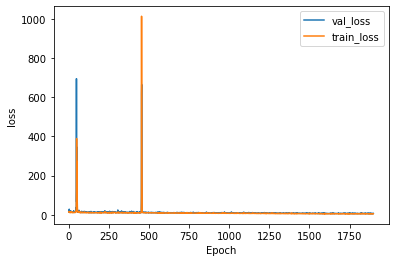

In [13]:
Y_pred_validate = model.predict(X_validate)

x = list(range(1899))
vy = training.history['val_loss']
ty = training.history['loss']

plt.plot( x, vy[100:-1], label='val_loss')
plt.plot( x, ty[100:-1], label='train_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

# Testing

In [18]:
Y_pred = model.predict(X_test)

print("Explained variance: " + str(metrics.explained_variance_score(Y_test, Y_pred)))
print("Max Error: " + str(metrics.max_error(Y_test, Y_pred)))
print("Mean absolute error: " + str(metrics.mean_absolute_error(Y_test, Y_pred)))
print("Mean squared error: " + str(metrics.mean_squared_error(Y_test, Y_pred)))
print("Root Mean squared error: " + str(metrics.mean_squared_error(Y_test, Y_pred, squared=False)))
print("R2: " + str(metrics.r2_score(Y_test, Y_pred)))

Explained variance: 0.7944570143464286
Max Error: 34.82658767700195
Mean absolute error: 6.752410474813209
Mean squared error: 89.32291979088507
Root Mean squared error: 9.451080350461796
R2: 0.7847516312494738
